In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import yt
from yt import YTArray, YTQuantity
import trident
import numpy as np
import sys
import h5py as h5


import seaborn as sns
import palettable
sns.set_style("ticks",{'axes.grid': True, 'grid.linestyle': '--'})

sys.path.append('../analysis')
import spectrum_generating_tools as spg
import ion_plot_definitions as ipd
import plotting_tools as pt



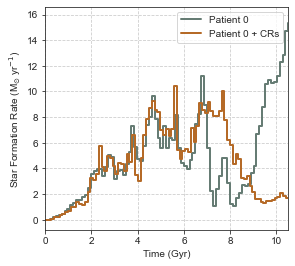

In [2]:
# star formation history plot

#load data
f = h5.File('../../data/simulation_data/sfh_data.h5', 'r')

fig, ax = plt.subplots(figsize = (4.2, 3.8))
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('Star Formation Rate (M$_{\odot}$ yr$^{-1}$)')
ax.set_xlim(0, 10.5)


color_list = palettable.wesanderson.Moonrise2_4.mpl_colors[:2]
for model, label, color in zip(['p0', 'agncr'], ['Patient 0', 'Patient 0 + CRs'], color_list):
     
    x = np.array(f['time_%s'%model])
    y = np.array(f['sfh_%s'%model])
    
    x = np.vstack((x[:-1], x[1:])).reshape((-1), order = 'F')
    y = np.vstack((y, y)).reshape((-1), order = 'F')

    ax.plot(x, y, linewidth = 2, label = label, color = color)

ax.legend()
fig.tight_layout()
plt.savefig('../../plots/sfh.png', dpi = 300)


yt : [INFO     ] 2021-02-08 17:52:06,941 Parameters: current_time              = 3.398869692888919e+17 s
yt : [INFO     ] 2021-02-08 17:52:06,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-08 17:52:06,942 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-08 17:52:06,943 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-08 17:52:06,944 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-08 17:52:06,944 Parameters: current_redshift          = 0.24979488244391623
yt : [INFO     ] 2021-02-08 17:52:06,945 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-02-08 17:52:06,945 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-02-08 17:52:06,946 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-02-08 17:52:06,946 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-02-08 17:52:06,955 Allocating for 1.506e+06 p

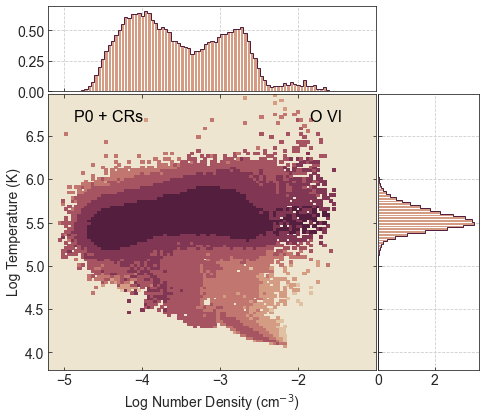

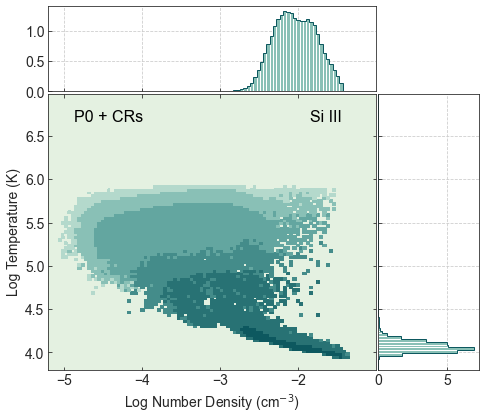

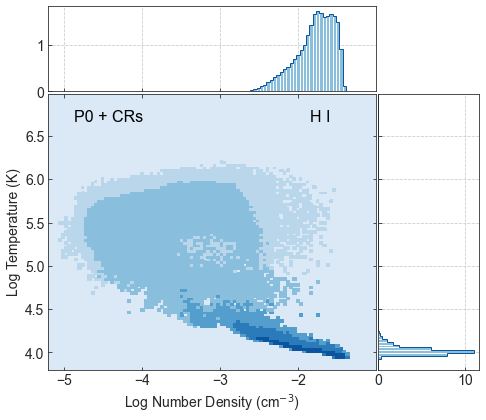

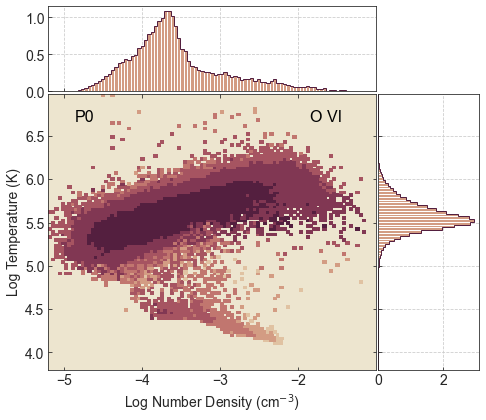

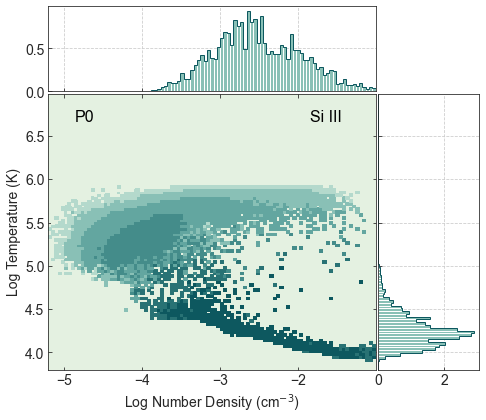

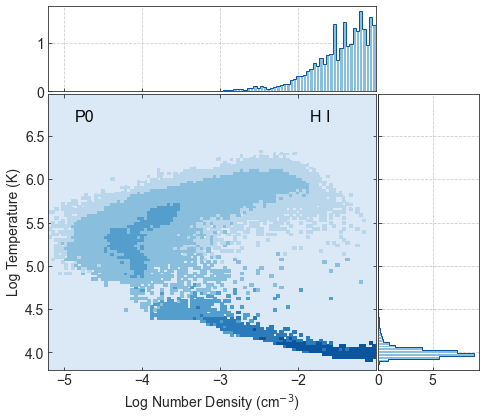

In [91]:

def plot_phase(model, ion = 'O VI'):
    
    ds, gcenter, bv = spg.load_simulation_properties(model)
    trident.add_ion_fields(ds, ions = [ion])  
    
    sp1 = ds.sphere(gcenter, (15, 'kpc'))
    sp2 = ds.sphere(gcenter, (200, 'kpc'))
    sp = sp2 - sp1

    logx_list = np.log10(sp[xfield])
    logy_list = np.log10(sp[yfield])
    
    ion_name = ipd.return_ion_prefix(ion)
    mass_list = sp['%s_mass'%ion_name].in_units('Msun')


    xlims = (-5.2, -1.01)
    ylims = (3.8, 6.99)

    xedges = np.linspace(xlims[0], xlims[1], 100)
    yedges = np.linspace(ylims[0], ylims[1], 100)
    weights = mass_list
    normed = True
    #weights = None

    H, xedges, yedges = np.histogram2d(logx_list, logy_list, bins = (xedges, yedges), weights = weights, normed = normed)
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)


    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.11, 0.65
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(7, 5.9))
    fs = 14
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True, labelsize = fs)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False, labelsize = fs)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelsize = fs)

    ax_scatter.set_xlim(xlims[0], xlims[1])
    ax_scatter.set_ylim(ylims[0], ylims[1])
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    ax_scatter.set_xlabel('Log Number Density (cm$^{-3}$)', fontsize = fs)
    ax_scatter.set_ylabel('Log Temperature (K)', fontsize = fs)

   # palette = sns.color_palette("Blues")
#    cmap = cmListedColormap(palette)
    palette = pt.get_palette(ion)
    cmap = ListedColormap(palette)
    background = palette[0]

    ax_scatter.pcolormesh(X, Y, H, norm = LogNorm(), cmap = cmap)
    ax_scatter.set_facecolor(background)


    # add ion and model labels
    xtext = 0.8*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.9*(ylims[1] - ylims[0]) + ylims[0]
    ax_scatter.text(xtext, ytext, ion, fontsize = fs+2, color = 'black')
    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    if model == 'P0':
        ax_scatter.text(xtext, ytext, model, fontsize = fs+2, color = 'black')
    else:
        ax_scatter.text(xtext, ytext, 'P0 + CRs', fontsize = fs+2, color = 'black')


    
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, color = palette[2])
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, 
                  histtype = 'step', color = palette[-1])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', color = palette[2])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', histtype = 'step', color = palette[-1])


    ion = ion.replace(" ", "")
    plt.savefig('../../plots/phase_%s_%s.png'%(ion, model), dpi = 300)

    
model_list = ['P0_agncr', 'P0']
ion_list = ['O VI', 'Si III', 'H I']

#ion_list = ['H I']

for model in model_list:
    for ion in ion_list:
        plot_phase(model, ion)

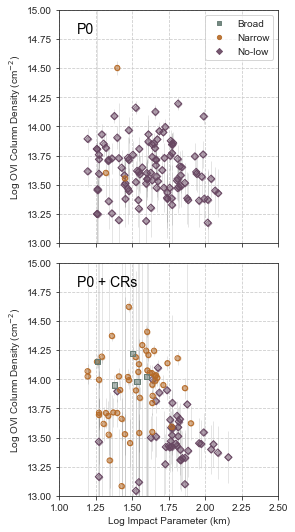

In [108]:
# plotting O VI label plots
def plot_ovi(xfield):
    ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
                zcen_sd_list, ray_id_list, model_list, vel_list, impact_list, ovi_label_list = pt.load_csv_data()

    if xfield == 'bval':
        x_list = np.log10(b_list)
        xerr_list = np.log10(berr_list)
        xlims = (0.7, 2)
        xlabel = 'Log Doppler b (km/s)'
    elif xfield == 'impact':
        x_list = np.log10(impact_list)
        xerr_list = np.zeros(len(impact_list))
        xlims = (1, 2.5)
        xlabel = 'Log Impact Parameter (km)'

    
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (4.2, 7.5), sharex = True, sharey = True)
  #  ax.plot([0.7, 2.7], [13.5, 15.5], color = 'black', linestyle = 'dashed')

    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    for col, model in enumerate(['P0', 'P0agncr']):
        mask = (ion_list == 'OVI') & (model_list == model)
        total_ovi = pt.get_total_column(ray_id_list[mask], logN_list[mask])
       # for q in range(len(ion_list[mask])):
        #    print(ray_id_list[mask][q], ion_list[mask][q], logN_list[mask][q], total_ovi[q])

       # ax[col].scatter(x_list[mask], total_ovi, color = 'black', s = 23, zorder = 10)
        for i, label in enumerate(label_list):
            mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
           # ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = legend_list[i])
            x = x_list[mask]
            xerr = xerr_list[mask]
            y = logN_list[mask]
            yerr = logNerr_list[mask]
            ax[col].errorbar(x, y, xerr=xerr, yerr=yerr, linewidth = 0.5, 
                             color = 'black', linestyle = '', alpha = 0.2, zorder = 0)
            ax[col].scatter(x, y, s = 26, marker = marker_list[i], 
                       edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
            ax[col].scatter(x, y, s = 23, marker = marker_list[i], 
                       color = color_list[i], zorder= zorder_list[i], alpha = 0.5)
            # dummy for legend
            ax[col].scatter(-1, -1, s = 18, marker = marker_list[i], 
                       color = color_list[i], label = legend_list[i], alpha = 0.9)
                
        ax[col].set_ylabel('Log OVI Column Density (cm$^{-2}$)')
     
    ylims = (13, 15)
    ax[0].set_xlim(xlims)#0.7, 2)
    ax[0].set_ylim(ylims)
    ax[1].set_xlabel(xlabel)

    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.9*(ylims[1] - ylims[0]) + ylims[0]
    ax[0].text(xtext, ytext, 'P0', fontsize = 14, color = 'black')
    ax[1].text(xtext, ytext, 'P0 + CRs', fontsize = 14, color = 'black')
    
    ax[0].legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_%s_col.png'%xfield, dpi = 300)

plot_ovi('impact')

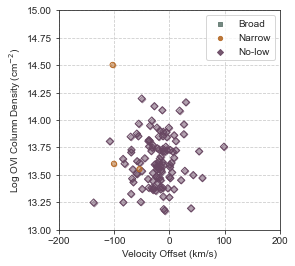

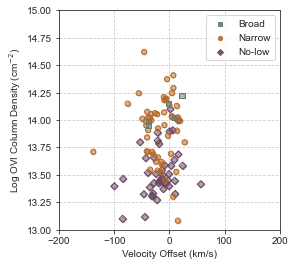

In [3]:
# plotting O VI impact plots
def plot_bval_ovi(model):
    ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
                zcen_sd_list, ray_id_list, model_list, vel_list, impact_list, ovi_label_list = pt.load_csv_data()

    fig, ax = plt.subplots(figsize = (4.2, 3.8))

    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    

    for i, label in enumerate(label_list):
        mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
       # ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = legend_list[i])
        ax.scatter(vel_list[mask], logN_list[mask], s = 26, marker = marker_list[i], 
                   edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
        ax.scatter(vel_list[mask], logN_list[mask], s = 23, marker = marker_list[i], 
                   color = color_list[i], zorder= zorder_list[i], alpha = 0.5)
        # dummy for legend
        ax.scatter(-1, -1, s = 18, marker = marker_list[i], 
                   color = color_list[i], label = legend_list[i], alpha = 0.9)
    ax.set_xlim(-200, 200)
    ax.set_ylim(13.0, 15.0)   
    ax.set_xlabel('Velocity Offset (km/s)')
    ax.set_ylabel('Log OVI Column Density (cm$^{-2}$)')
    ax.legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_vel_col_%s.png'%model, dpi = 300)

for model in ['P0', 'P0agncr']:
    plot_bval_ovi(model)

<ipython-input-7-1f4b92a1a282>:36: RuntimeWarning: divide by zero encountered in log10
  return l, np.log10(temperature), np.log10(density), np.log10(metallicity), vlos, np.log10(ocol), np.log10(sicol), np.log10(hcol)
No handles with labels found to put in legend.


0 -35.26131251249045 -24.852778039541317
1 3.3513765162975226 6.250206218257634
2 -7.753330112267824 -1.7411756115825172
3 -276.958432965299 84.39775332998362
4 -inf 13.854156738545315
5 -inf 13.184878305285004
6 -inf 18.13726441474624


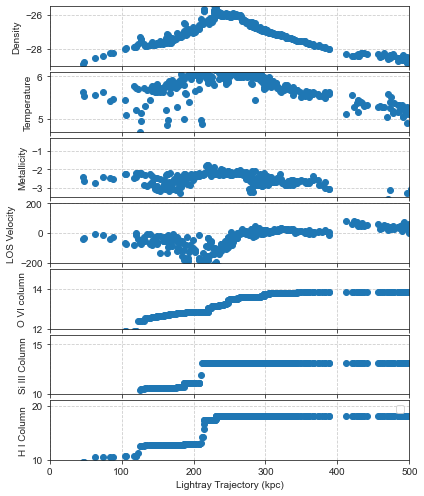

<Figure size 432x288 with 0 Axes>

In [7]:
def los_vel(vx, vy, vz, bv = [0, 0, 0], normal = [0, 0, 1]):
    vx = np.array(vx - bv[0])
    vy = np.array(vy - bv[1])
    vz = np.array(vz - bv[2])
    #vel = np.column_stack((vx, vy, vz))

    normal_mag = np.linalg.norm(normal)
    normal = np.divide(normal, normal_mag)
    #normal = np.column_stack(normal)
    
    #print(vel.shape, normal.shape)
    #v_dot_norm = np.dot(vel, normal) 
    v_dot_norm = vx*normal[0] + vy*normal[1] + vz*normal[2]
   # print(v_dot_rhat.shape)
    return v_dot_norm
def load_sightline_scatter_data(sim, ray_id, output = 3195):
    plot_data = h5.File('../../data/unanalyzed_spectra/ray_%s_%i_%i.h5'%(sim, output, ray_id), 'r')['grid']

    l = YTArray(plot_data['l'], 'cm')
    l = np.array(l.in_units('kpc'))
    #l -= l[0]
    temperature = np.array(plot_data['temperature'])
    density     = np.array(plot_data['density'])
    metallicity = np.array(plot_data['metallicity'])
    vx          = np.array(plot_data['relative_velocity_x']) / 1e5 # converting to km/s
    vy          = np.array(plot_data['relative_velocity_y']) / 1e5 # converting to km/s
    vz          = np.array(plot_data['relative_velocity_z']) / 1e5 # converting to km/s

    vlos        = np.array(plot_data['velocity_los']) / 1e5
    dl = np.array(plot_data['dl'])
    
    # O VI and H I column densities
    ocol  = np.cumsum(dl * np.array(plot_data['O_p5_number_density']))
    sicol = np.cumsum(dl* np.array(plot_data['Si_p3_number_density']))
    hcol  = np.cumsum(dl * np.array(plot_data['H_p0_number_density']))
    return l, np.log10(temperature), np.log10(density), np.log10(metallicity), vlos, np.log10(ocol), np.log10(sicol), np.log10(hcol)
    
def plot_sightline_data(sim, ray_id, output = 3195):
    l, temperature, density, metallicity, vlos, ocol, sicol, hcol = \
        load_sightline_scatter_data(sim, ray_id, output = output)

    field_list = [density, temperature, metallicity, vlos, ocol, sicol, hcol]
    ylim_list = [(-29, -25.5), (4.7, 6.1), (-3.5, -.3), (-200, 200), (12, 15), (10, 16), (10, 21)]    
    ylabel_list = ['Density (g cm$^{-3}$)', 'Temperature (K)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'O VI Column Density (cm$^{-2}$)', 'Si III Column Density (cm$^{-2}$)', 'H I Column Density (cm$^{-2}$)']
    ylabel_list = ['Density', 'Temperature', 'Metallicity', 'LOS Velocity', 'O VI column', 'Si III Column', 'H I Column']
    
    fig, ax = plt.subplots(nrows = len(field_list), ncols = 1 , figsize = (6, len(field_list)),
                               sharex=True, sharey=False)
    for i in range(len(field_list)):

        data = field_list[i]
        ax[i].scatter(l, data)

        ax[i].set_xlim(0, 500)
#        ax[i].set_ylim(ylim_list[i])
        yrange = max(data) - min(data)
        print(i, min(data), max(data))
        
     #   ax[i].set_ylim(min(data) - 0.1*yrange, max(data) + 0.2*yrange)
        ylims = ylim_list[i]
        ax[i].set_ylim(ylims[0], ylims[1])
        ax[i].set_ylabel(ylabel_list[i])
        
   # ax[4].scatter(l, hcol, label = 'Local Column Density')
   # ax[5].scatter(l, ocol, label = 'Local Column Density')
    ax[len(field_list)-1].set_xlabel
    ax[-1].set_xlabel('Lightray Trajectory (kpc)')
    ax[len(field_list)-1].legend()
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.1)
    plt.show()

    plt.savefig('../../plots/sightline_data_%s_%i.png'%(sim, ray_id), dpi = 300)
plot_sightline_data('P0', 5)

<ipython-input-7-1f4b92a1a282>:36: RuntimeWarning: divide by zero encountered in log10
  return l, np.log10(temperature), np.log10(density), np.log10(metallicity), vlos, np.log10(ocol), np.log10(sicol), np.log10(hcol)


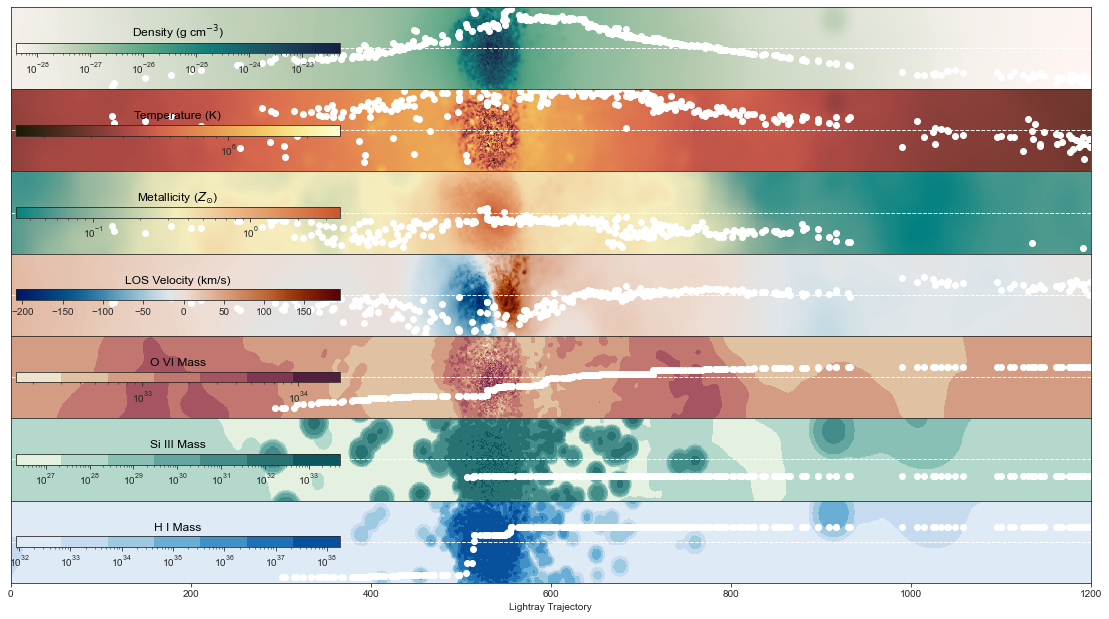

In [8]:

def los_vel(vx, vy, vz, bv = [0, 0, 0], normal = [0, 0, 1]):
    vx = np.array(vx - bv[0])
    vy = np.array(vy - bv[1])
    vz = np.array(vz - bv[2])
    #vel = np.column_stack((vx, vy, vz))

    normal_mag = np.linalg.norm(normal)
    normal = np.divide(normal, normal_mag)

    v_dot_norm = vx*normal[0] + vy*normal[1] + vz*normal[2]
   # print(v_dot_rhat.shape)
    return v_dot_norm

def plot_ray_image(model, ray_id):

    f = h5.File('../../data/ray_files/ray_image_data_%s_3195_%i.h5'%(model, ray_id), 'r')

    #print(list(f.keys()))
    #params = {"xtick.color" : "white", 
    #          "ytick.color" : "white"} 
   # plt.rcParams.update(params)
    field_list = ['density', 'temperature', 'metallicity', 'velocity_los',  'O_p5_mass', 'Si_p2_mass', 'H_p0_mass']
         #         'O_p5_number_density', 'Si_p2_number_density', 'H_p0_number_density']
    ylim_list = [(-29, -25.5), (4.7, 6.1), (-3.5, -.3), (-200, 200), (12, 15), (12, 16), (12, 21)]
    zlim_list  = [(3e-29, 1e-25), (8e4, 1e6), (3e-3, 1), (-200, 200), (1e13, 3e15),
                  (1e13, 3e16), (1e13, 1e21)]
    ylabel_list = ['Density (g cm$^{-3}$)', 'Temperature (K)', 'Metallicity ($Z_{\odot}$)', 
                        'LOS Velocity (km/s)', 'O VI Mass', 'Si III Mass', 'H I Mass']
                   #'O VI Column Density (cm$^{-2}$)',
                    #   'Si III Column Density (cm$^{-2}$)', 'H I Column Density (cm$^{-2}$)']

    l, temperature, density, metallicity, vlos, ocol, sicol, hcol = \
        load_sightline_scatter_data(model, ray_id)
    scatter_field_list = [ density, temperature, metallicity, vlos, ocol, sicol, hcol]
    
    fig, ax = plt.subplots(nrows = 7, ncols =1, figsize = (15, 8))
    for i, field in enumerate(field_list):
        if field == 'velocity_los':
            vx = np.array(f['velocity_x']) / 1e5
            vy = np.array(f['velocity_y']) / 1e5
            vz = np.array(f['velocity_z']) / 1e5
            ray_direction = spg.calculate_ray_direction(ray_id, ray_data_file = '../../data/random_sightlines.dat')
            image = los_vel(vx, vy, vz, bv = spg.load_bulk_velocity(model), normal = ray_direction)
            norm = None
        else:
            image = np.array(f[field])
            norm = LogNorm()
        if field == 'metallicity':
            image *= 77.22007722007721  # converting from code units to zsun

        im = ax[i].pcolormesh(image.T, norm = norm, cmap = pt.get_cmap(field))#,
#                              vmin = zlim_list[i][0], vmax = zlim_list[i][1])
        ax[i].axhline(40, linewidth = 1, color = 'white', linestyle = 'dashed')
        cbax = inset_axes(ax[i], width = "30%", height = "13%", loc = 6)
        cbar = fig.colorbar(im, cax=cbax, orientation = 'horizontal')
        cbar.ax.set_title(ylabel_list[i], color = 'black')
        
        
        # scatter data        
        data_xrange = 500.
        plot_xrange = 1200.
        
        data_yrange = np.abs(ylim_list[i][1] - ylim_list[i][0])
        plot_yrange = 80.
        
        # convert data to image units
        data = scatter_field_list[i]
        mask = (data > ylim_list[i][0]) & (data < ylim_list[i][1])
        x = l[mask] * plot_xrange / data_xrange
        y = (data[mask] - ylim_list[i][0]) * plot_yrange / data_yrange

        ax[i].scatter(x, y, color = 'white')
        
        if i < len(field_list) -1:
            ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim(0, 1200)
        ax[i].set_ylim(0, 80)

    ax[-1].set_xlabel('Lightray Trajectory')
    
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    #plt.savefig('../../plots/ray_P0_3195_%i.png'%ray_id, dpi = 300)
    plt.savefig('test.png', dpi= 300)
    f.close()
    
plot_ray_image('P0', 5)

yt : [INFO     ] 2021-02-12 18:17:04,747 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-02-12 18:17:04,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-12 18:17:04,748 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-12 18:17:04,749 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-12 18:17:04,749 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-12 18:17:04,750 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-02-12 18:17:04,750 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-02-12 18:17:04,751 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-02-12 18:17:04,751 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-02-12 18:17:04,752 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-02-12 18:17:04,769 Allocating for 3.151e+07 p

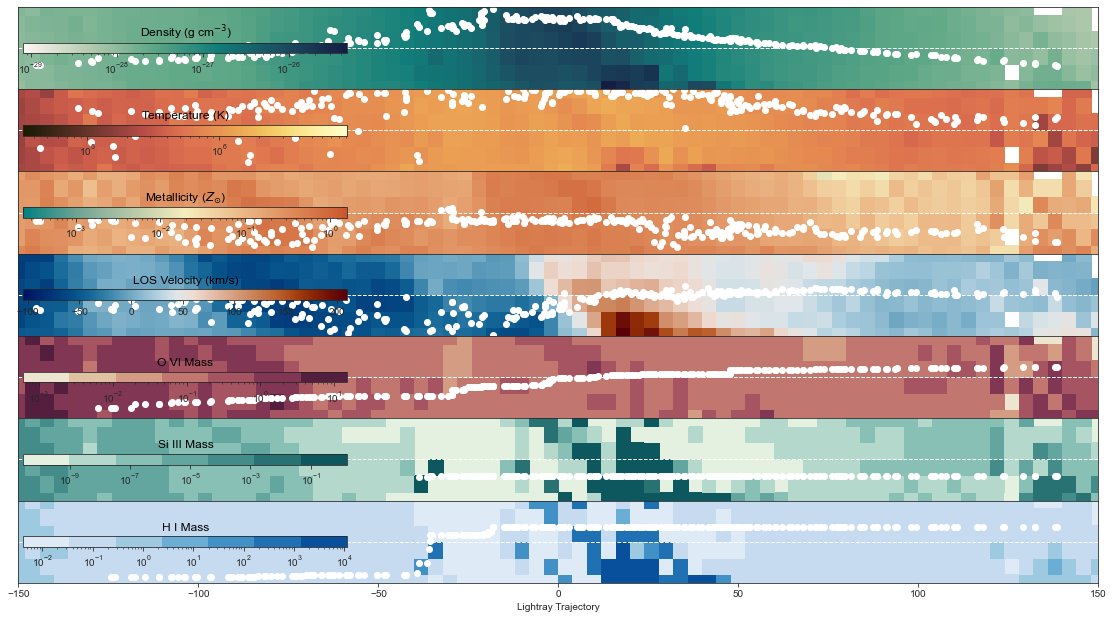

In [11]:

field_list = ['density', 'temperature', 'metallicity', 'velocity_los',  'O_p5_mass', 'Si_p2_mass', 'H_p0_mass']
unit_list = ['g/cm**3', 'K', 'Zsun', 'km/s', 'Msun', 'Msun', 'Msun']
ylim_list = [(-29, -25.5), (4.7, 6.1), (-3.5, -.3), (-200, 200), (12, 15), (12, 16), (12, 21)]
zlim_list  = [(3e-29, 1e-25), (8e4, 1e6), (3e-3, 1), (-200, 200), (1e13, 3e15),
              (1e13, 3e16), (1e13, 1e21)]
ylabel_list = ['Density (g cm$^{-3}$)', 'Temperature (K)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'O VI Mass', 'Si III Mass', 'H I Mass']
               #'O VI Column Density (cm$^{-2}$)',
                #   'Si III Column Density (cm$^{-2}$)', 'H I Column Density (cm$^{-2}$)']


def plot_ray_image(model, ray_id):
    ds, gcenter, bv = spg.load_simulation_properties(model)

    # load ray positions
    ray_data_file = '../../data/unanalyzed_spectra/%s_z0.25_ray_data.dat'%model
    xi, yi, zi, xf, yf, zf =\
            np.loadtxt(ray_data_file, skiprows = 1, unpack = True, usecols = (5, 6, 7, 8, 9, 10))
    ray_start = ds.arr([xi[ray_id], yi[ray_id], zi[ray_id]], 'kpc')
    ray_end   = ds.arr([xf[ray_id], yf[ray_id], zf[ray_id]], 'kpc')
    ray_direction = ray_end - ray_start
    ray_center = ray_start + 0.5*ray_direction
    normal_vector = ds.arr(gcenter, 'kpc') - ray_center
   # normal_vector = np.cross(normal_vector, ray_direction)

    l, temperature, density, metallicity, vlos, ocol, sicol, hcol = \
        load_sightline_scatter_data(model, ray_id)
    scatter_field_list = [ density, temperature, metallicity, vlos, ocol, sicol, hcol]
    
    
    fig, ax = plt.subplots(nrows = 7, ncols =1, figsize = (15, 8))
    
    s = ds.cutting(normal_vector, ray_center)
    xcut = s[('gas', 'relative_x')].in_units('kpc')
    ycut = s[('gas', 'relative_y')].in_units('kpc')
    zcut = s[('gas', 'relative_z')].in_units('kpc')  
    xlims = (-200, 200)
    ylims = (-200, 200)
    normed = False
    nbins = 100
    # first calculate how many cells / particls in each bin to divide out later
    divide_factor, xedges, yedges = np.histogram2d(xcut, ycut, range = [xlims, ylims], bins = nbins,
                                       weights = s[('gas', 'ones')], normed = normed)
    
    for i, field in enumerate(field_list):  
        if field == 'velocity_los':
            V = s[('Gas', 'Velocities')].in_units(unit_list[i])
            vx = V[:, 0].d
            vy = V[:, 1].d 
            vz = V[:, 2].d 
       
            vlos = los_vel(vx, vy, vz, bv = spg.load_bulk_velocity(model), normal = ray_direction)
            norm = None
            image, xedges, yedges = np.histogram2d(xcut, ycut, range = [xlims, ylims], bins = nbins,
                                       weights = vlos, normed = normed)
        else:
            image, xedges, yedges = np.histogram2d(xcut, ycut, range = [xlims, ylims], bins = nbins,
                                       weights = s[('gas', field)].in_units(unit_list[i]), normed = normed)
            norm = LogNorm()
            
        image /= divide_factor
        X, Y = np.meshgrid(xedges, yedges)
        cmap = pt.get_cmap(field)
        
        background = pt.get_palette(field)[0]
        if i > 3:
            ax[i].set_facecolor(background)
        im = ax[i].pcolormesh(X, Y, image.T, norm = norm, cmap = cmap)#,
#                              vmin = zlim_list[i][0], vmax = zlim_list[i][1])
        ax[i].axhline(0, linewidth = 1, color = 'white', linestyle = 'dashed')

        cbax = inset_axes(ax[i], width = "30%", height = "13%", loc = 6)
        cbar = fig.colorbar(im, cax=cbax, orientation = 'horizontal')
        cbar.ax.set_title(ylabel_list[i], color = 'black')
        
        
        # scatter data        
        data_xrange = 500.
        plot_xrange = 1200.
        
        data_yrange = np.abs(ylim_list[i][1] - ylim_list[i][0])
        plot_yrange = 20.
        
        # convert data to image units
        data = scatter_field_list[i]
        mask = (data > ylim_list[i][0]) & (data < ylim_list[i][1])
        x = l[mask] - 250 # centering ray on 0; lengthof ray is 500 kpc
        y = (data[mask] - ylim_list[i][0]) * plot_yrange / data_yrange - 10

        ax[i].scatter(x, y, color = 'white')
        
        if i < len(field_list) -1:
            ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim(-150, 150)
        ax[i].set_ylim(-10, 10)

    ax[-1].set_xlabel('Lightray Trajectory')
    
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    #plt.savefig('../../plots/ray_P0_3195_%i.png'%ray_id, dpi = 300)
    plt.savefig('test2.png', dpi= 300)
    
plot_ray_image('P0', 5)

yt : [INFO     ] 2021-02-12 19:02:39,494 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-02-12 19:02:39,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-12 19:02:39,495 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-12 19:02:39,496 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-12 19:02:39,497 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-12 19:02:39,497 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-02-12 19:02:39,498 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-02-12 19:02:39,498 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-02-12 19:02:39,499 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-02-12 19:02:39,499 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-02-12 19:02:39,514 Allocating for 3.151e+07 p


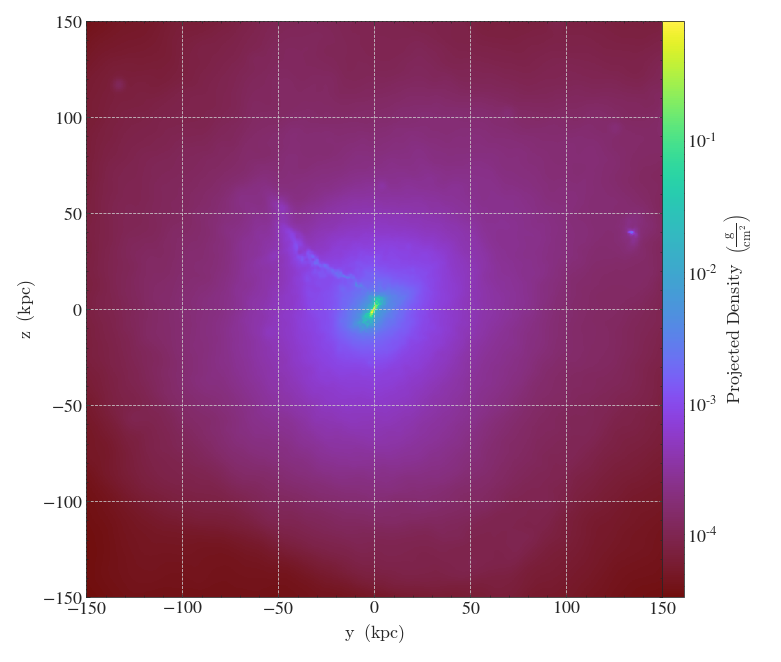

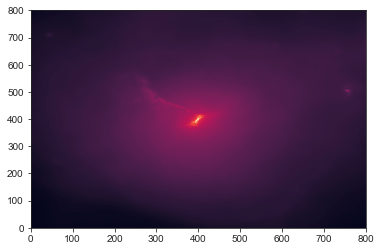

In [40]:
model = 'P0'
ds, gcenter, bv = spg.load_simulation_properties(model)

#ray_data_file = '../../data/unanalyzed_spectra/%s_z0.25_ray_data.dat'%model
ray_data_file ='../../data/random_sightlines.dat' #centered at zero, not gcenter

ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
                zcen_sd_list, ray_id_list, model_list, vel_list, impact_list, ovi_label_list = pt.load_csv_data()


p = yt.ProjectionPlot(ds, 'x', ('gas', 'density'), center = gcenter, width = (300, 'kpc'))
p.show()
frb = p.data_source.to_frb((300, 'kpc'), 800)

data = frb[('gas', 'density')]
fig, ax = plt.subplots()
ax.pcolormesh(data, norm = LogNorm())



73


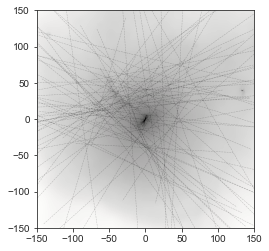

In [41]:
ray_data_file ='../../data/random_sightlines.dat' #centered at zero, not gcenter
xi, yi, zi, xf, yf, zf =\
        np.loadtxt(ray_data_file, skiprows = 1, unpack = True, usecols = (2, 3, 4, 5, 6, 7))

fig, ax = plt.subplots()
x = np.linspace(-150, 150, 800)
y = np.linspace(-150, 150, 800)

cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap
ax.pcolormesh(x, y, data, norm = LogNorm(), cmap = cmap)
ax.set_aspect(1)
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
counter = 0
for ray_id in range(200):
    # x projection
    mask = (ray_id_list == ray_id) & (ion_list == 'OVI') & (logN_list > 13.5) & (model_list == model)
    if len(ovi_label_list[mask]) > 0:
        ray_start = np.array([yi[ray_id], zi[ray_id]])
        ray_end = np.array([yf[ray_id], zf[ray_id]])
        ax.plot([yi[ray_id], yf[ray_id]], [zi[ray_id], zf[ray_id]], linewidth = 0.5, linestyle = 'dashed', color = 'black', alpha = 0.2)
        counter +=1
print(counter)
   # ray_start = ds.arr([xi[ray_id], yi[ray_id], zi[ray_id]], 'kpc')
   # ray_end   = ds.arr([xf[ray_id], yf[ray_id], zf[ray_id]], 'kpc')
    
    #

In [ ]:
# next steps: calculate where along the sightline the OVI is > tahn some percent of it's final column density. 
#consider this where the absorption happened
# then, place scatter point at that point on the line along projected sightline
# not confirm orientation between sightlines on plot and in ray riles